#### Copyright (C) 2020 Sobhan Moradiyan Daghigh - All Rights Reserved
### Implementation of a Hierarchical Agglomerative Clustering on a professors' fields dataset
### Using spaCy model which is based on nlp and is very commen in text semantic similarities
##### 12/5/2020

### Hii. 

In [1]:
# !pip install spacy

In [2]:
# !python -m spacy download en_core_web_md

In [3]:
# !python -m spacy link en_core_web_md en

In [4]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import spacy

# I'm gonna use medium size of this model
nlp = spacy.load('en_core_web_md')

### Reading dataset

In [5]:
main_dataset = pd.read_excel("./DatasetForClustering.xlsx")
main_dataset.head()

,ID,ScopH,ScopIntpp,GoSchopp,GoSchcite,GoSchH,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,297,15.0,17.0,NaN,NaN,NaN,Zinc,Cadmium,Soil pollution,Organoclay,Calcareous Soil,Bioavailability,Sulfur-oxidizing bacteria,Manures,Soil solutions,Salinity
1,242,12.0,10.0,NaN,NaN,NaN,Yield,Medicinal Plant,Essential oils,Replacement corm,Germination,Azotobacter chroococcum,Crocus sativus,Phytotoxicity,Pseudomonas putida,Calcareous Soil
2,693,NaN,34.0,NaN,NaN,NaN,Wireless sensor networks,Quality of service,Sensor nodes,Sensor networks,Network lifetime,Congestion control,Smart Grid,Internet protocols,Routing protocols,Clustering
3,129,19.0,31.0,259.0,2593.0,25.0,Wireless sensor networks,Quality of service,Congestion control,Sensor nodes,Network lifetime,Sensor networks,Smart Grid,Routing protocols,Internet protocols,Clustering
4,556,7.0,8.0,42.0,283.0,10.0,Wireless sensor networks,Routing protocols,Quality of service,Sensor nodes,Smart Grid,Directional sensor network,Fairness,Coverage,Wireless multimedia sensor network,Optimization problems


### Filtering the needed attrs

In [6]:
main_dataset = main_dataset.drop(['ScopH', 'ScopIntpp', 'GoSchopp', 'GoSchcite', 'GoSchH'], axis=1)
main_dataset.head()

,ID,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,297,Zinc,Cadmium,Soil pollution,Organoclay,Calcareous Soil,Bioavailability,Sulfur-oxidizing bacteria,Manures,Soil solutions,Salinity
1,242,Yield,Medicinal Plant,Essential oils,Replacement corm,Germination,Azotobacter chroococcum,Crocus sativus,Phytotoxicity,Pseudomonas putida,Calcareous Soil
2,693,Wireless sensor networks,Quality of service,Sensor nodes,Sensor networks,Network lifetime,Congestion control,Smart Grid,Internet protocols,Routing protocols,Clustering
3,129,Wireless sensor networks,Quality of service,Congestion control,Sensor nodes,Network lifetime,Sensor networks,Smart Grid,Routing protocols,Internet protocols,Clustering
4,556,Wireless sensor networks,Routing protocols,Quality of service,Sensor nodes,Smart Grid,Directional sensor network,Fairness,Coverage,Wireless multimedia sensor network,Optimization problems


In [7]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        638 non-null    int64 
 1   Field 1   638 non-null    object
 2   Field 2   638 non-null    object
 3   Field 3   638 non-null    object
 4   Field 4   636 non-null    object
 5   Field 5   630 non-null    object
 6   Field 6   627 non-null    object
 7   Field 7   626 non-null    object
 8   Field 8   621 non-null    object
 9   Field 9   620 non-null    object
 10  Field 10  614 non-null    object
dtypes: int64(1), object(10)
memory usage: 55.0+ KB


### Filling in the missing values with a whitespace according to the alorithm which I'm using

In [8]:
main_dataset = main_dataset.fillna(' ')
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        638 non-null    int64 
 1   Field 1   638 non-null    object
 2   Field 2   638 non-null    object
 3   Field 3   638 non-null    object
 4   Field 4   638 non-null    object
 5   Field 5   638 non-null    object
 6   Field 6   638 non-null    object
 7   Field 7   638 non-null    object
 8   Field 8   638 non-null    object
 9   Field 9   638 non-null    object
 10  Field 10  638 non-null    object
dtypes: int64(1), object(10)
memory usage: 55.0+ KB


### As I'll explain more accurate about the spaCy, I need to merge the features for calculating the similarities


In [9]:
def connect_features():
    df = pd.DataFrame()
    df['ID'] = main_dataset['ID']
    df['Fields'] = main_dataset[['Field 1', 'Field 2', 'Field 3', 'Field 4', 'Field 5',
                            'Field 6', 'Field 7', 'Field 8', 'Field 9', 'Field 10']].agg('-'.join, axis=1)
    return df

### Now I need a single column which contains all featurs 

In [10]:
dataset = connect_features()
dataset.head()

,ID,Fields
0,297,Zinc-Cadmium-Soil pollution-Organoclay-Calcare...
1,242,Yield-Medicinal Plant-Essential oils-Replaceme...
2,693,Wireless sensor networks-Quality of service-Se...
3,129,Wireless sensor networks-Quality of service-Co...
4,556,Wireless sensor networks-Routing protocols-Qua...


### Here, the most important part of the code, I'll calculate the distance using spaCy 
### spaCy is a model for word vectorization based on semantic similarity 
#### For more info about spaCy click [here](https://spacy.io/usage/vectors-similarity).

In [11]:
def spacy_semantic_similarity(sentence1, sentence2):
    sentence1 = nlp(sentence1)
    sentence2 = nlp(sentence2)
    
    return sentence1.similarity(sentence2)

### Theres some examples to get more about spaCy

In [12]:
spacy_semantic_similarity('dog', 'cat')

0.8016854705531046

In [13]:
spacy_semantic_similarity('pen', 'pencil')

0.7085842403739737

### Combination of them

In [14]:
spacy_semantic_similarity('dog-pen', 'cat-pencil')

0.8442632419880388

### Check the preority
#### > No preority

In [15]:
spacy_semantic_similarity('dog-pen', 'pencil-cat')

0.8442632438866646

### Ok, now try to make the similarity matrix for dataset
#### Notice: This matrix takes a little time to be made

In [16]:
similarity_matrix = np.zeros((dataset.shape[0], dataset.shape[0]))
for person1 in dataset.iterrows():
    for person2 in dataset.iterrows():
        similarity_matrix[person1[0], person2[0]] = spacy_semantic_similarity(person1[1]['Fields'], person2[1]['Fields'])

### Here we go :)

In [18]:
similarity_matrix

array([[1.        , 0.8636068 , 0.62884218, ..., 0.68453741, 0.84662399,
        0.64814572],
       [0.8636068 , 1.        , 0.60285631, ..., 0.71408574, 0.86481099,
        0.68310445],
       [0.62884218, 0.60285631, 1.        , ..., 0.66912191, 0.71993989,
        0.76247785],
       ...,
       [0.68453741, 0.71408574, 0.66912191, ..., 1.        , 0.83309422,
        0.83355889],
       [0.84662399, 0.86481099, 0.71993989, ..., 0.83309422, 1.        ,
        0.83549071],
       [0.64814572, 0.68310445, 0.76247785, ..., 0.83355889, 0.83549071,
        1.        ]])

### Now try to make a dendrogram to have a good visualization on datas
### Then decide number of clusters

### Fisrt, I'm gonna use 'complete' method for agglomerative clustering 

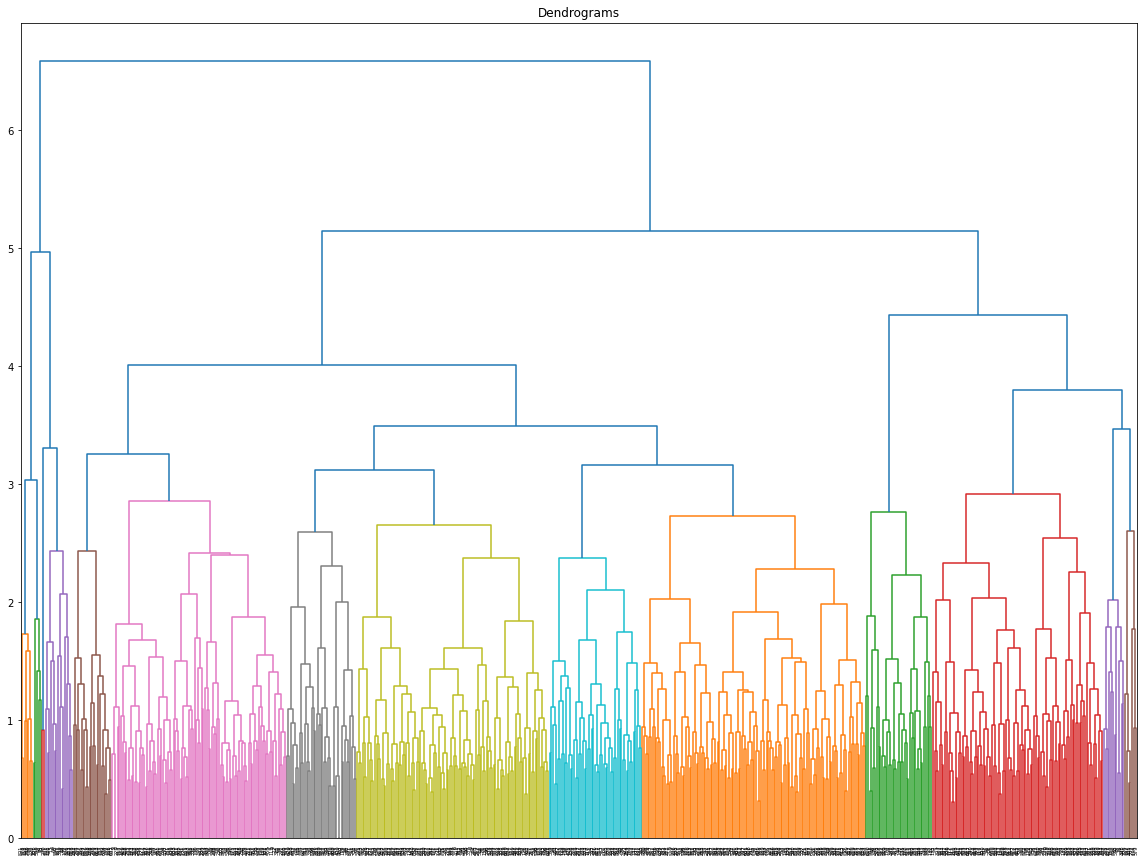

In [19]:
fig = plt.figure(figsize=(20, 15))
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(similarity_matrix, method='complete'), color_threshold=3)

In [20]:
fig.savefig('main_dendrogram.jpg', format='jpg', bbox_inches='tight')

### Make a dendrogram with a cut-off on 5 levels

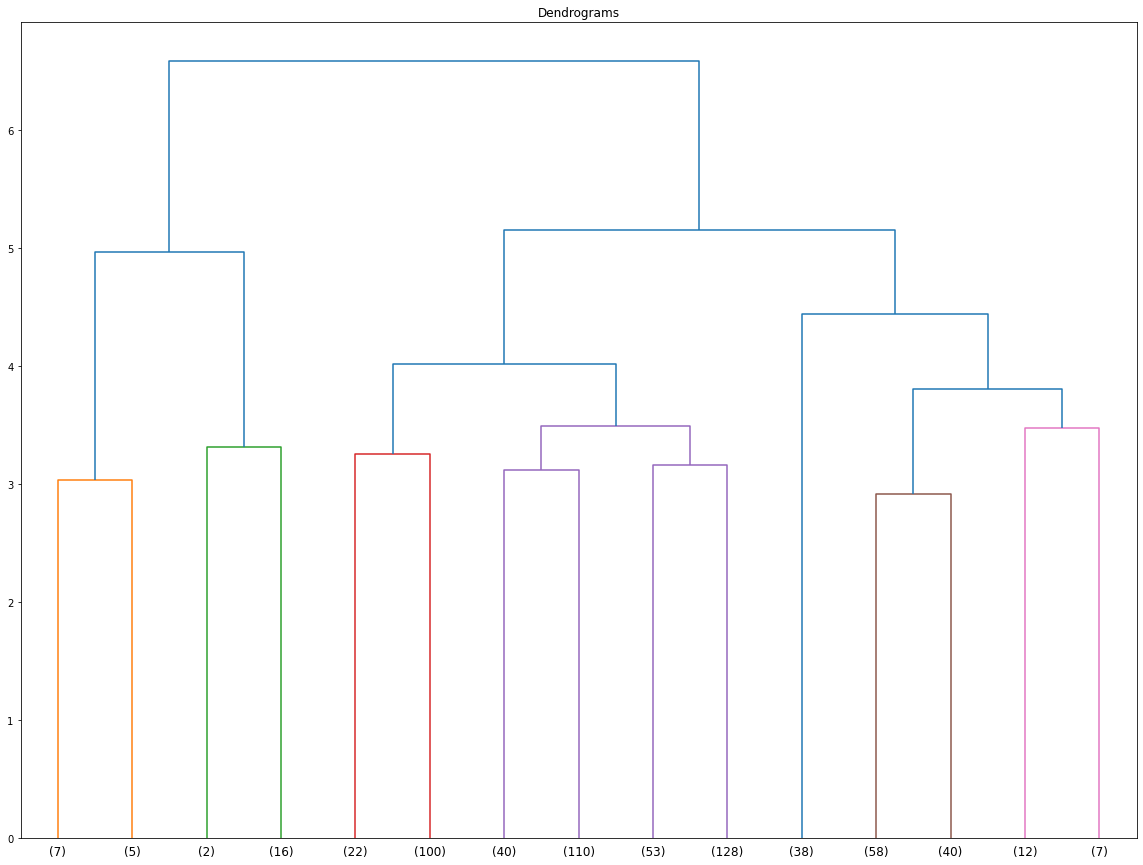

In [21]:
fig = plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(similarity_matrix, method='complete'), p=15, truncate_mode='lastp', color_threshold=3.5)

In [22]:
fig.savefig('cut_dendrogram.jpg', format='jpg', bbox_inches='tight')

### Now I'm gonna use 'ward' method for clustering

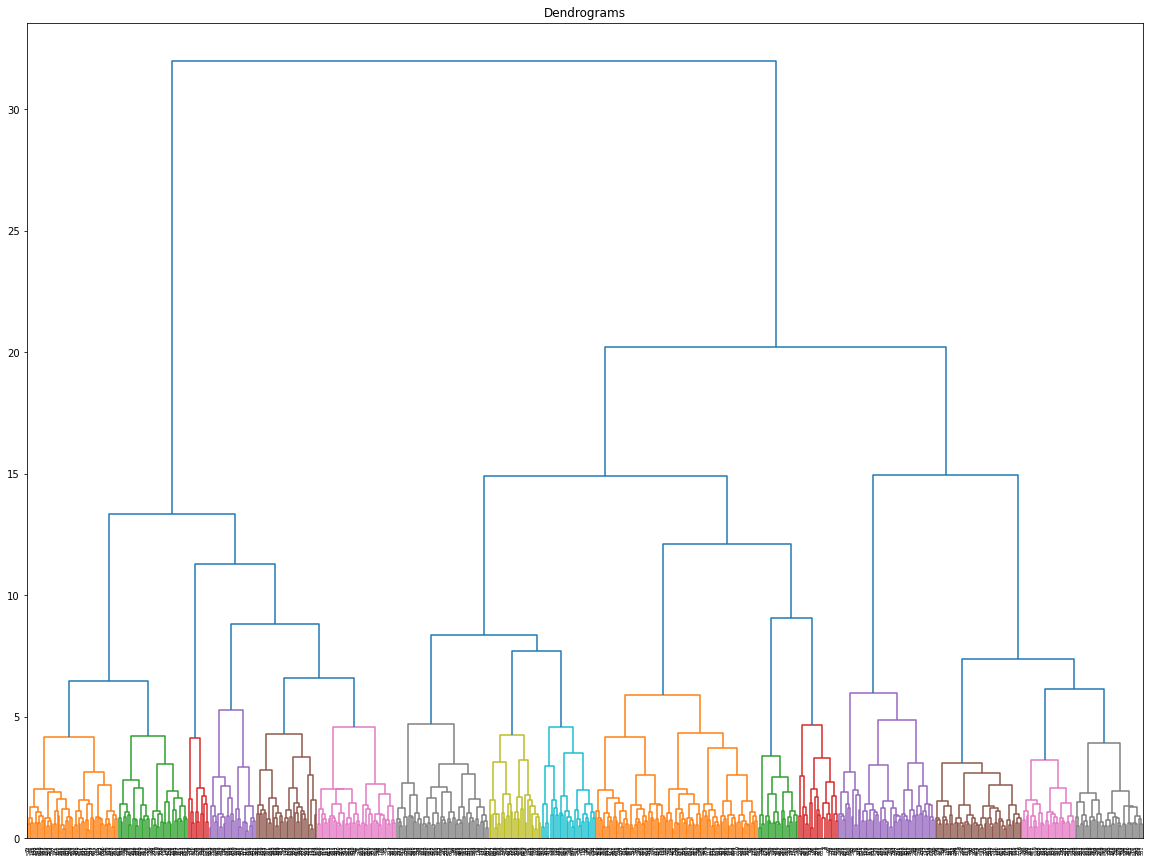

In [23]:
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(similarity_matrix, method='ward'), color_threshold=6)

### As u saw, It seems the 'complete' method is more suitable for our datas 
### But I'm not sure.

### Suppose that I'm right and  the 'complete' method is better at clustering these datas 
### So according to the dendrogram, It seems that theres 8 clusters

In [24]:
model = AgglomerativeClustering(n_clusters=15, linkage='complete').fit(similarity_matrix)
dataset['cluster'] = model.labels_
dataset.head(4)

,ID,Fields,cluster
0,297,Zinc-Cadmium-Soil pollution-Organoclay-Calcare...,5
1,242,Yield-Medicinal Plant-Essential oils-Replaceme...,6
2,693,Wireless sensor networks-Quality of service-Se...,0
3,129,Wireless sensor networks-Quality of service-Co...,0


### Now try to do grouping by, on clusters to have fields of each cluster togather

In [25]:
groups = dataset.groupby(by=['cluster'])
groups.first()

,ID,Fields
cluster,,
0,693,Wireless sensor networks-Quality of service-Se...
1,433,Webometrics-Website analysis-Iranian universit...
2,847,Water footprint-OpenFOAM-Semi-arid region-Stab...
3,571,Wheat\n\nSENSITIVITY-ANALYSIS-Energy productiv...
4,768,Wheat Production-Sensitivity analysis-BDLRF al...
5,297,Zinc-Cadmium-Soil pollution-Organoclay-Calcare...
6,242,Yield-Medicinal Plant-Essential oils-Replaceme...
7,298,Progesterone-Cattle-Dairy cows-Reproduction-Su...
8,111,Stainless steel-Pitting-Corrosion-A. Stainless...


In [26]:
for grp, pdf in groups:
    print("\n\nCluster: ", grp, "     Count: ", len(pdf))
    print(('  -  '.join(set(('-'.join(set(pdf['Fields'].tolist()))).split('-')))).replace('\n', ' '))



Cluster:  0      Count:  100
Android  -  Resource constrained project scheduling  -  Hydrofoils  -  Eikonal equation  -  Hilbert C*  -  Slow Wave Sleep  -  Large  -  Pareto distribution  -  Shallow foundations  -  Asymptotic normality  -  Nucleon  -  Wind farm  -  combustor  -  Noise/outlier  -  Current  -  Methods: numerical  -  Non  -  Shannon entropy  -  Vibration suppressors  -  gravity correspondence  -  Fatigue crack propagation  -  Embedded coding  -  Sensor networks  -  Creep  -  Sleep Spindle  -  Delta  -  Transition state  -  Normalized impedance  -  Tracks  -  Hydrogen bonds  -  Distributed parameter line model  -  Fisher information  -  Ofdm  -  Inverse Sampling  -  Nucleosomes  -  Anisotropy  -  Large deflection  -  Kwong function  -  Software quality  -  Software design  -  Ontology  -  Monolithic integrated circuits  -  Damage diagnosis  -  Finite volume method  -  Baer invariant  -  Hertzian contacts  -  Positive block matrix  -  Support vector data description  -  Po

#### Yohaa :) DID IT.

### Notice: The priority option is ignored and theres no any difference between Fileld columns